# How does TESS handle cosmic rays?

"Cosmic rays", a general term for both Galactic cosmic rays and solar energetic particles, are high energy particles that can cause flux increases in pixels on detectors of space telescopes like TESS (See [this link](https://imagine.gsfc.nasa.gov/science/toolbox/cosmic_rays1.html) for more information on Cosmic rays). These particles can either directly cause an increase in flux by hitting the detector (a primary event), or they can cause a cascade of other particles which themselves cause spurious flux on the detector (secondary events). These particles are always streaming through the TESS instruments, and so they impact our data. Cosmic rays can look a lot like interesting astrophysical variability, and so the TESS mission products use different methods to handle them.

In this notebook you will learn about the different ways cosmic rays are dealt with by TESS mission products, and learn how that might impact your science with TESS data.

# Introduction to TESS data products

TESS has three main data products. We will briefly discuss them here, and lay out how cosmic rays are addressed in the data files. 


Full Frame Images (FFIs): An FFI is the full set of all science and collateral pixels across all four CCDs of a given camera. In the prime mission (Cycles 1 and 2), they had a cadence of 30 minutes, then 10 minutes in the first extension (Cycles 3 and 4), and 200 seconds in the second extension (Cycle 5+). The images are built up from 2-second exposures, with Cosmic Ray Mitigation (CRM) being implemented onboard as described in Section 1.

Target Pixel Files (TPFs): These are cutouts of the pixels surrounding pre-selected targets of interest and are created on the ground. TPFs have a cadence of 120 seconds only in the primary mission, but from the extended mission onwards they may also have a cadence of 20 seconds. Cosmic Ray Mitigation is applied onboard for 120-second targets, but not for 20-second targets.


Lightcurves (LC): Files containing the brightness of a given target over time for pre-selected targets. Lightcurves are created by combining the flux within a given aperture around the target on the TPF. These have cadences of either 2 minutes or, beginning in the extended mission, 20 seconds.


The TPFs and LCs are created by the Science Processing Operations Center (SPOC) pipeline using raw data from TESS. The SPOC is located at NASA Ames and the pipeline, based on that developed for Kepler (see Jenkins 2016), is used to process and correct the raw TESS data. LCs created from 120 second cadence TPF data have already been corrected for cosmic rays, and as such need no further CRM. LCs created from 20-second cadence data undergo an extra step of processing by SPOC in which cosmic rays are identified and removed. See Section 2 for further details.


# Method 1: Cosmic Ray Mitigation

Cosmic Ray Mitigtaion (CRM) is a strategy employed by TESS during data collection. The strategy is intended to remove large outliers created by cosmic ray impacts from the pixel data. CRM is applied to each pixel in the following steps:

- Data are collected from the CCDs every two seconds. FFI and shorter cadence data are created by summing 2s images. 
- For each pixel, the spacecraft computer identifies and removes both the brightest and faintest value in groups of 10 exposures.
- The values of the remaining 8 exposures are summed and used to create the relevant data product, i.e. the above procedure is completed 6 times and coadded to create the 120 second cadence TPFs with 96 second total integration time. The procedure is 10 times and co-added to create 200 second FFIs for Cycles 5+, 30 times for the 10 minute FFIs during the first extended mission, and 90 times to create one 30-minute FFI during the prime mission, resulting in 160-second, and 480-second, and 1440-second integration times respectively. 

Below is a representation of what occurs on-board, for each pixel for each 20 second frame

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

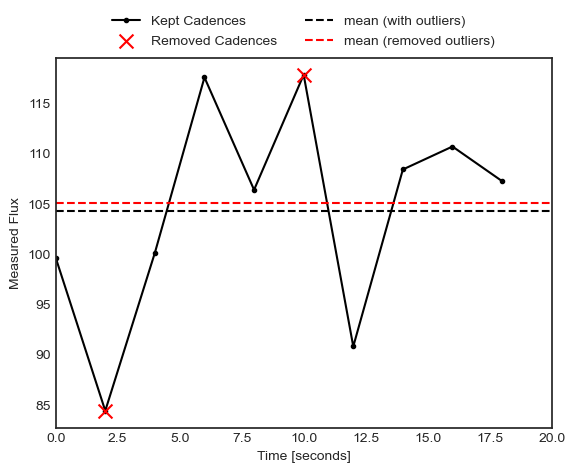

In [2]:
f = np.random.normal(100, 10, size=10)

fig, ax = plt.subplots()
ax.plot(np.arange(0, 20, 2), f, c='k', zorder=1, marker='.', label='Kept Cadences')
ax.scatter([np.argmin(f)*2, np.argmax(f)*2], [f.min(), f.max()], c='r', marker='x', s=100, zorder=10, label='Removed Cadences')

ax.hlines( np.mean(f), 0,24,linestyles='dashed', color='k', label='mean (with outliers)')
ax.hlines( np.mean(np.delete(f, [np.argmin(f), np.argmax(f)])), 0,24,linestyles='dashed', color='r', label='mean (removed outliers)')

ax.set_xlim(0,20)
ax.set(xlabel='Time [seconds]', ylabel='Measured Flux')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15),
          fancybox=False, shadow=False, ncol=2)

CRM is "baked in" to the data, it can not be removed, and it can not be reversed.

**Crucially, for 20-second TPF data taken by the mission and delivered, this strategy is not employed.** 20 second data consists of 10 co-added 2 second frames, with no frames removed.   

In addition, for every 20 second TPF, a 120 second TPF (with on-board CRM) is also created and archived. Meaning, for any target with 20 second TESS data there is:

- A 20-second TPF without on-board Cosmic Ray Mitigation
- A 20-second LC, made from the 20-second TPF, without on-board CRM
- A 120-second TPF with on-board Cosmic Ray Mitigation
- A 120-second LC, made from the 120-second TPF, with on-board CRM

Because of this, simply coadding the 20-second data from TESS will not produce exactly the 120 second data.

After the 20-second data is on the ground, cosmic rays are removed using a different method during processing with SPOC. Therefore any SPOC TPF or LC products you download will have cosmic ray correction that *is* reversable. The details of this process will be discussed in more detail in Section 2 below.

# What are the impacts of Cosmic Ray Mitigation?

CRM has many impacts on the data products that you get, here are some of the key impacts:

- **Cosmic rays in the data are significantly reduced.** Large, single cadence deviations are removed.
- **The raw target flux from data with on-board CRM is 80% of the true flux, because 20% of the data is removed by CRM.** The TESS mission pipeline corrects for this in the light curve data products delivered to the archive.
- **Extremely fast, asymmetric, astrophysical variability (on time-scales of 20 seconds or less) may be adveresly affected.** The CRM might, for example, remove extremely short term stellar flares.
- **The noise distributions of the data are affected.** Because cosmic rays do not occur in every 20 second co-add, the CRM will alter the pixel time-series of the true target flux. This can impact the noise distribution and properties of the target.

# Method 2: SPOC Pipeline Cosmic Ray Identification and Removal

Once data is received on the ground, it is processed by the TESS pipeline. Because CRM is not used on board for 20 second data, the SPOC pipeline runs an additional step on these data to identify cosmic rays and remove them. The removed cosmic rays are stored in the FITS file and can be accessed and added back to the TPF if desired. To briefly summarize the process, cosmic rays are:

- Identified in each 20-second image.
- In images where there is a cosmic ray identified, the amplitude of the cosmic ray in each pixel is recorded.
- Cosmic rays are removed (subtracted) from the pixel level data.
- The time, pixel positions, and flux value removed are recorded to an array as an extension to the fits file.

Below is an example of the information in the cosmic ray extension. For further details on the process, see the [data release notes from Sector 27](https://archive.stsci.edu/missions/tess/doc/tess_drn/tess_sector_27_drn38_v02.pdf), Section 4.1. 



In [3]:
import lightkurve as lk
import numpy as np
import matplotlib.pyplot as plt

def load_cosmicray_extension(tpf):
    """Function to load the cosmic ray extension into a datacube
    
    Parameters:
    -----------
    tpf: lk.TargetPixelFile
        Input Target Pixel File
    
    Returns:
    -------
    cr: np.ndarray
        Array containing cosmic ray fluxes of shape tpf.shape
    """
    cadenceno = np.asarray(tpf.cadenceno)

    # Get cosmic ray information
    l = np.where([hdu.name == 'TARGET COSMIC RAY' for hdu in tpf.hdu])[0]
    if len(l) != 1:
        raise ValueError("TPF product has no cosmic ray extension.")
    hdu = tpf.hdu[l[0]]
    c, x, y, f = [hdu.data[attr].copy() for attr in ['CADENCENO', 'RAWX', 'RAWY', 'COSMIC_RAY']]
    if len(c) == 0:
        raise ValueError("No cosmic rays identified. Is this a 20-second dataset?")
    x -= tpf.column
    y -= tpf.row
    
    # Mask down to only cosmic rays in cadences within the TPF
    k = np.in1d(c, cadenceno)
    c, x, y, f = c[k], x[k], y[k], f[k]
        
    # Map cosmic ray cadences to array indices
    r = {cadenceno[idx]:idx for idx in range(tpf.shape[0])}
    inv = np.asarray([r[c1] for c1 in c])
    
    # Build a cube
    cr = np.zeros(tpf.shape)
    cr[inv, y, x] = f
    return cr

In the example below, we make use of a TPF file. If you need a refresher on how to handle TPF files before proceeding, check out [this tutorial](https://docs.lightkurve.org/tutorials/1-getting-started/what-are-targetpixelfile-objects.html).

In [4]:
#Get an example 20-s TPF file
tpf = lk.search_targetpixelfile('Kepler 10', mission='TESS', author='SPOC', exptime=20, sector=40).download()

<AxesSubplot:title={'center':'Target ID: 377780790, Cadence: 5025018'}, xlabel='Pixel Column Number', ylabel='Pixel Row Number'>

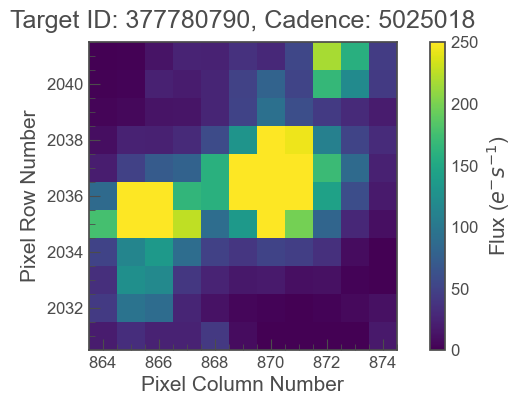

In [5]:
tpf.plot(vmin=0, vmax=250)

In [6]:
#Get the cosmic ray data using the function we defined above
cosmic_ray_cube = load_cosmicray_extension(tpf)

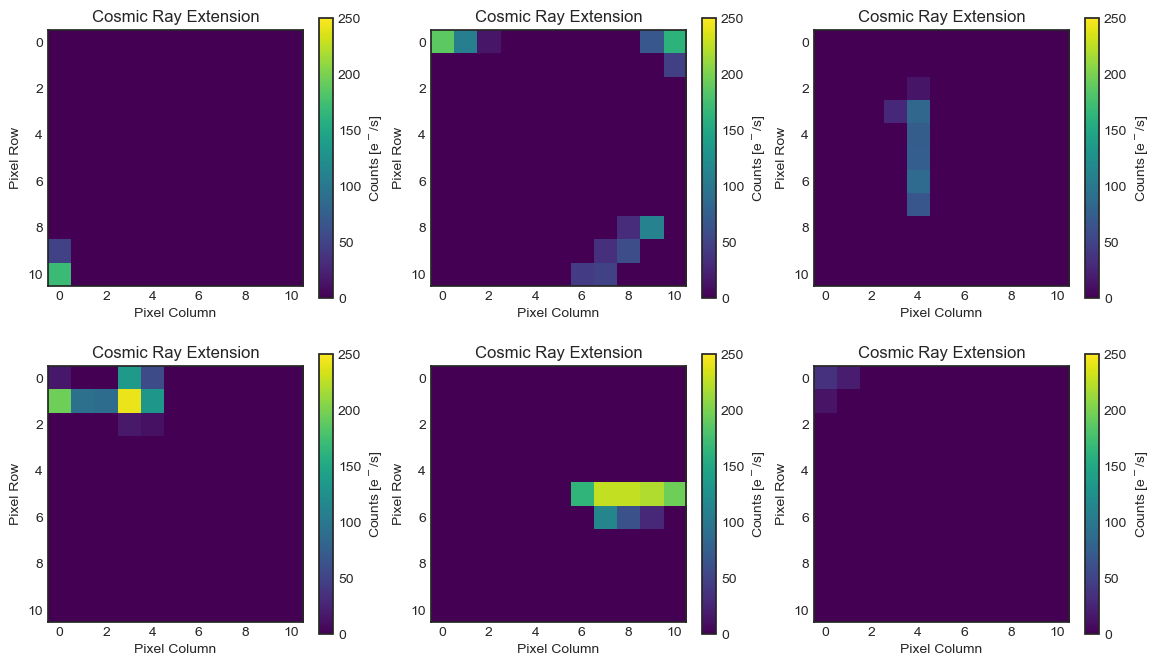

In [7]:
#Plot some random examples of the CRs in the data
ax_num = 0
fig, ax = plt.subplots(2,3, figsize=(14,8))
for ii in range(100,1000, 10):
    #only plot if a CR was found in the frame
    if np.sum(cosmic_ray_cube[ii]) > 0:  
        im = ax.flat[ax_num].imshow(cosmic_ray_cube[ii], cmap='viridis',vmin=0, vmax=250)
        ax.flat[ax_num].set(xlabel='Pixel Column', ylabel='Pixel Row', title='Cosmic Ray Extension')
        cbar = plt.colorbar(im, ax=ax.flat[ax_num])
        cbar.set_label('Counts [e$^-$/s]')
        ax_num +=1
        #Stop after plotting 6
        if ax_num==6:
            break
        
plt.show()

The cosmic ray extension can be used to re-inject the cosmic rays into the pixel data. For example, using the pipeline processed pixels we can simply add the cosmic rays back into the simple aperture photometry [(SAP)](https://heasarc.gsfc.nasa.gov/docs/tess/LightCurveFile-Object-Tutorial.html). 

<AxesSubplot:xlabel='Time - 2457000 [BTJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

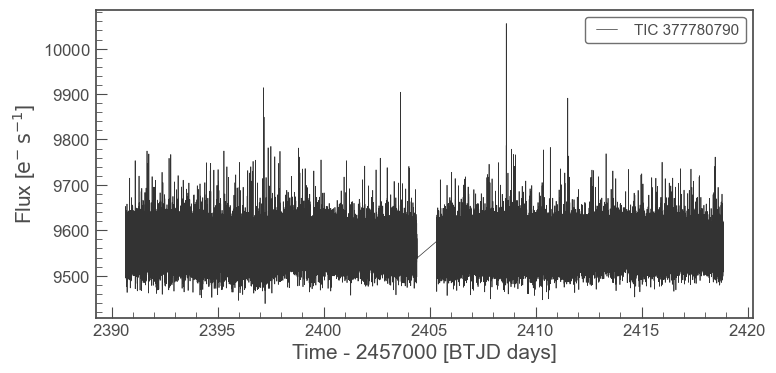

In [8]:
lc = tpf.to_lightcurve(aperture_mask=tpf.pipeline_mask)
lc.plot()

(9000.0, 20000.0)

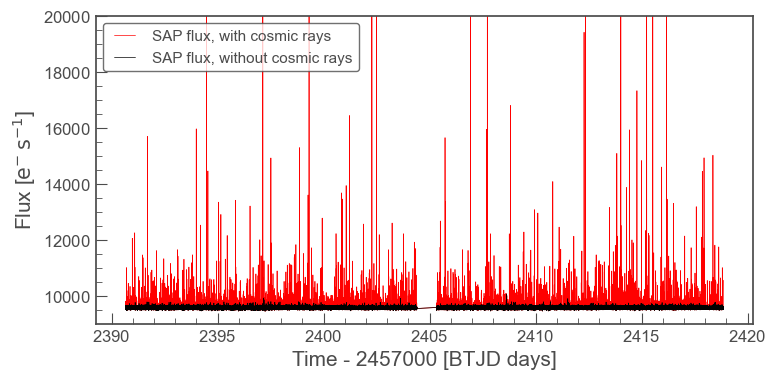

In [9]:
tpf_with_cr = (tpf + cosmic_ray_cube)
lc_with_cr = tpf_with_cr.to_lightcurve(aperture_mask=tpf.pipeline_mask)
ax = lc_with_cr.plot(c='r', label='SAP flux, with cosmic rays')
lc.plot(ax=ax, c='k', label='SAP flux, without cosmic rays')
plt.ylim(9000,20000)

The cosmic rays that are removed are stored in the TPF files. In order to add CRs back into a LC directly, you would need to sum the CR flux in all pixels of the photometric aperture. For the SAP flux, you can simply add this flux in. However, for the corrected Presearch Data Conditioning SAP [(PDC-SAP)](https://heasarc.gsfc.nasa.gov/docs/tess/LightCurveFile-Object-Tutorial.html) lightcurves, you will need to normalize the cosmic ray correction by an extra factor for all pixels within the chosen aperture as follows:

$f'_{PDCSAP\_flux}(n) = f_{PDCSAP\_flux}(n)+\dfrac{\Delta f(n)}{FLFRCSAP}$

where $f'_{PDCSAP\_flux}(n)$ is the UNCORRECTED flux (ie, with cosmic rays injected back in), $f_{PDCSAP\_flux}(n)$ is the PDC-SAP corrected flux, $\Delta f(n)$ is the flux removed by the cosmic ray correction, and FLFRCSAP is the flux fraction correction. The latter value is stored in the LC and TPF binary table headers. 

Additional outliers caused by uncorrected cosmic rays may still remain, particularly when the target is bright. In this case, the suspected CRs will be labeled with a data quality bit of 10 (quality value = 512) as impulsive outliers. Users should consider their science objectives and determine whether or not these outliers should be masked.  

# Conclusion

Cosmic rays are frequently seen in TESS data. The on-board cosmic ray mitigation system is effective at removing the majority of cosmic rays for FFI images and 120-second TPF and LCs. The on-board CRM system is not run for the 20-second data product, but rather cosmic arrays are corrected for by the SPOC pipeline. 

If you are an astronomer mostly interested in variability on time-scales much longer than 20 seconds, you are likely to only benefit from data that uses Cosmic Ray Mitigation. CRM will largely make your data less susceptible to significant upwards outliers.

If you are an astronomer mostly interested in short term flares or other impulsive events with time scales on the order of 20 seconds or less, CRM may hamper your investigations. Users may wish to use the TPF *without* cosmic rays removed and build a model that accounts for cosmic rays in their detection pipeline. In this case we recommend that you propose to the TESS General Investigator program to obtain 20 second data of your targets of interest. However, 20 second targets are a limited resource as they are a large volume of data, so there is more competition for those resources.